In [1]:
# --- Signature Verification with DenseNet169 ---

import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.densenet import DenseNet169, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import os


In [2]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [4]:
# ---------------- Dataset Paths ----------------
train_data_path = "C:/Users/nagas/Downloads/Signatures_Dataset/train"
validation_data_path = "C:/Users/nagas/Downloads/Signatures_Dataset/val"
test_data_path = "C:/Users/nagas/Downloads/Signatures_Dataset/test"   # now using folder, not just one image


In [5]:
# ---------------- Data Generators ----------------
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['forged', 'real'],
    shuffle=True
)

Found 4318 images belonging to 2 classes.


In [6]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    classes=['forged', 'real'],
    shuffle=True
)


Found 1233 images belonging to 2 classes.


In [7]:
test_generator = test_datagen.flow_from_directory(
    test_data_path,
    target_size=(224, 224),
    batch_size=1,    # test one by one
    class_mode='categorical',
    classes=['forged', 'real'],
    shuffle=False
)


Found 620 images belonging to 2 classes.


In [8]:
print("Total Training Images:", train_generator.samples)
print("Total Validation Images:", validation_generator.samples)
print("Total Test Images:", test_generator.samples)

Total Training Images: 4318
Total Validation Images: 1233
Total Test Images: 620


In [9]:
# ---------------- Model ----------------
base_model = DenseNet169(weights='imagenet', include_top=False, input_shape=(224,224,3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
num_classes = 2
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
# ---------------- Compile ----------------
model.compile(optimizer=Adam(learning_rate=1e-4),   # smaller LR to stabilize
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# ---------------- Callbacks ----------------
checkpoint = ModelCheckpoint("densenet_signature.keras", monitor='val_accuracy',
                             verbose=1, save_best_only=True, mode='max')
earlystop = EarlyStopping(monitor='val_accuracy', patience=5,
                          restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=3, min_lr=1e-7, verbose=1)

In [11]:
# ---------------- Training ----------------
history = model.fit(
    train_generator,
    epochs=10,   # can increase if needed
    validation_data=validation_generator,
    callbacks=[checkpoint, earlystop, reduce_lr]
)

C:\Users\nagas\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.6659 - loss: 0.6083
Epoch 1: val_accuracy improved from None to 0.73398, saving model to densenet_signature.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 1010s 7s/step - accuracy: 0.7277 - loss: 0.5232 - val_accuracy: 0.7340 - val_loss: 0.5556 - learning_rate: 1.0000e-04
Epoch 2/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9124 - loss: 0.2092
Epoch 2: val_accuracy improved from 0.73398 to 0.84672, saving model to densenet_signature.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 994s 7s/step - accuracy: 0.9166 - loss: 0.2027 - val_accuracy: 0.8467 - val_loss: 0.3640 - learning_rate: 1.0000e-04
Epoch 3/10
135/135 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.9608 - loss: 0.1101
Epoch 3: val_accuracy improved from 0.84672 to 0.85807, saving model to densenet_signature.keras
135/135 ━━━━━━━━━━━━━━━━━━━━ 998s 7s/step - accuracy: 0.9616 - loss: 0.1021 - val_accuracy: 0.8581 - val_loss: 0.3606 - learning_rate: 1.0000e-04
Epoch 4/10
135/135

In [12]:
import pickle

# Save training history as a pickle file
with open("training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)

print("✅ Training history saved as training_history.pkl")


✅ Training history saved as training_history.pkl


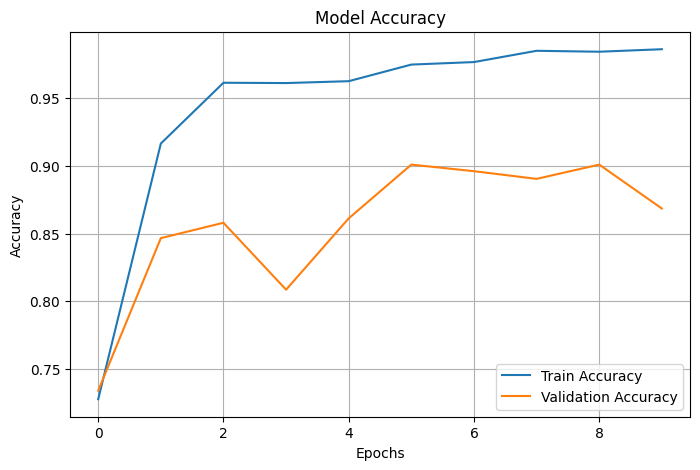

In [13]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

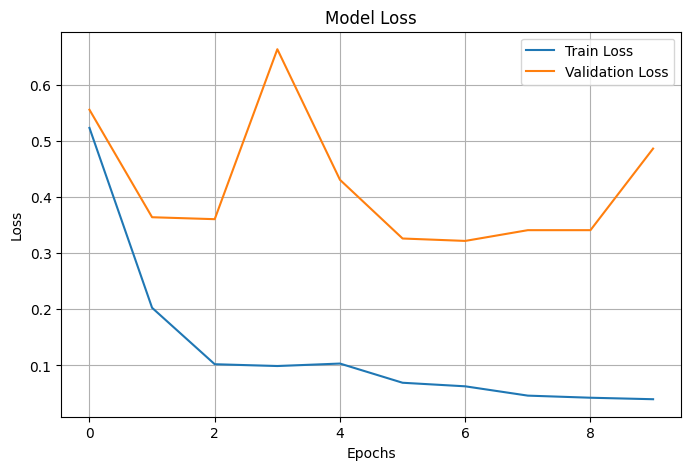

In [14]:
# Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# ---------------- Evaluate on Test Set ----------------
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

620/620 ━━━━━━━━━━━━━━━━━━━━ 176s 284ms/step - accuracy: 0.9210 - loss: 0.2356
Test Accuracy: 92.10%


In [15]:
!pip install seaborn

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import seaborn as sns


In [17]:
# ---------------- Classification Report ----------------
# Get predictions for all test images
y_true = test_generator.classes
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
class_labels = ['forged', 'real']
print("\nClassification Report:\n")
print(classification_report(y_true, y_pred_classes, target_names=class_labels))

620/620 ━━━━━━━━━━━━━━━━━━━━ 178s 282ms/step

Classification Report:

              precision    recall  f1-score   support

      forged       0.92      0.92      0.92       300
        real       0.92      0.93      0.92       320

    accuracy                           0.92       620
   macro avg       0.92      0.92      0.92       620
weighted avg       0.92      0.92      0.92       620



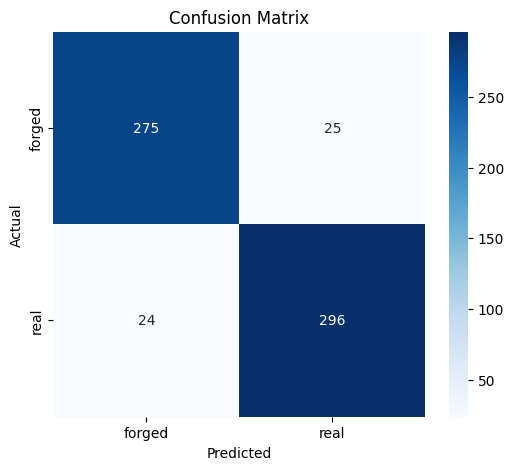

In [18]:
# ---------------- Confusion Matrix ----------------
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

In [19]:
# ---------------- ROC Curve & AUC ----------------
# If binary classification, take only one column (prob for class=1)
if y_pred.shape[1] == 2:  
    y_score = y_pred[:, 1]  # probability for 'real'
else:  
    raise ValueError("This code is set for binary classification only.")

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_score)
roc_auc = auc(fpr, tpr)


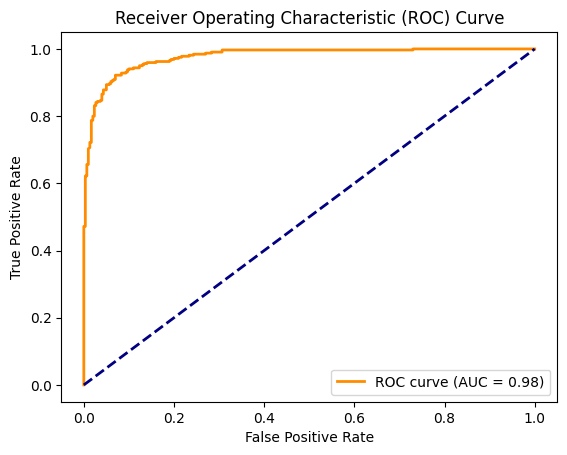

In [20]:
# Plot ROC Curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step


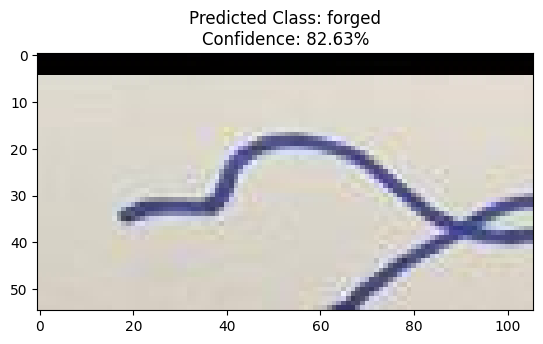

In [22]:
# ---------------- Predict and Show Sample ----------------
sample_img_path = test_generator.filepaths[0]   # first image in test set
test_image = image.load_img(sample_img_path, target_size=(224, 224))
test_image_array = image.img_to_array(test_image)
test_image_array = np.expand_dims(test_image_array, axis=0)
test_image_array = preprocess_input(test_image_array)

predictions = model.predict(test_image_array)
class_labels = ['forged', 'real']
predicted_class = class_labels[np.argmax(predictions)]
accuracy_percentage = np.max(predictions) * 100

plt.imshow(image.load_img(sample_img_path))
plt.title(f'Predicted Class: {predicted_class}\nConfidence: {accuracy_percentage:.2f}%')
plt.show()
